# Grok experiment exploratory analysis
The purpose of this notebook is to analyze the models from the grokking experiment.

## Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
base_folder = "/home/gridsan/kmurray/attract-or-oscillate/results/grok_experiment"
number_of_experiments = 30

## Load and visualize data

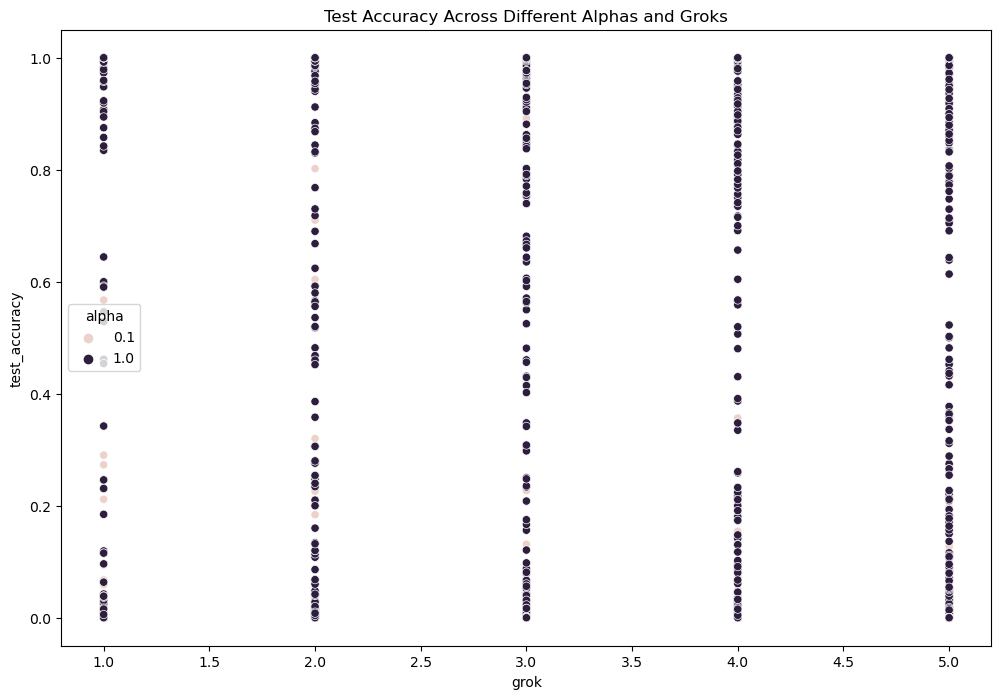

In [3]:
# Initialize a list to store all experiment and task data
experiments_data = []

for experiment_id in range(number_of_experiments):  # replace with actual number of experiments
    experiment_folder = os.path.join(base_folder, f"experiment_{experiment_id}")
    
    for task_id in range(96):
        task_folder = os.path.join(experiment_folder, f"task_{task_id}")
        
        # Load task parameters
        with open(os.path.join(task_folder, "params.json"), 'r') as f:
            params = json.load(f)
        
        # Load task results (modify based on your actual result structure)
        metrics_path = os.path.join(task_folder, "metrics_history.csv")
        if os.path.exists(metrics_path):
            metrics = pd.read_csv(metrics_path)
            
            # Find the row with the minimum 'test_loss'
            min_test_loss_row = metrics.loc[metrics['grok_loss'].idxmin()]
            
            experiments_data.append({
                'experiment_id': experiment_id,
                'task_id': task_id,
                'alpha': params['alpha'],
                'grok': params['grok'],
                'grok_label': params['grok_label'],
                'train_loss': min_test_loss_row.get('train_loss', None),
                'train_accuracy': min_test_loss_row.get('train_accuracy', None),
                'test_loss': min_test_loss_row.get('test_loss', None),
                'test_accuracy': min_test_loss_row.get('test_accuracy', None),
                'grok_loss':  min_test_loss_row.get('grok_loss', None),
                'grok_accuracy': min_test_loss_row.get('grok_accuracy', None),
            })

# Convert the list of dicts to a DataFrame
df = pd.DataFrame(experiments_data)

# Basic plotting for visual inspection (modify based on your specific needs)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='grok', y='test_accuracy', hue='alpha')
plt.title('Test Accuracy Across Different Alphas and Groks')
plt.show()

In [4]:
# Filtering rows where 'test_accuracy' is above 0.9 and grouping by 'experiment_id' to count them
successful_counts = df[df['test_accuracy'] > 0.99].groupby('experiment_id').size().reset_index(name='successful_count')

# If there are experiments with no successful trials, adding them to successful_counts DataFrame with a count of 0
all_experiments = df['experiment_id'].unique()
missing_experiments = set(all_experiments) - set(successful_counts['experiment_id'])
missing_df = pd.DataFrame(list(missing_experiments), columns=['experiment_id'])
missing_df['successful_count'] = 0

# Concatenating the DataFrames
successful_counts = pd.concat([successful_counts, missing_df], ignore_index=True)

# Finding the experiment with the minimum count
min_successful_experiment = successful_counts.loc[successful_counts['successful_count'].idxmin()]

experiment_id = min_successful_experiment['experiment_id']
successful_count = min_successful_experiment['successful_count']

print(f"The experiment with ID {experiment_id} had the fewest successful trials with {successful_count} trials having a test_accuracy above 0.99.")

The experiment with ID 26 had the fewest successful trials with 4 trials having a test_accuracy above 0.99.


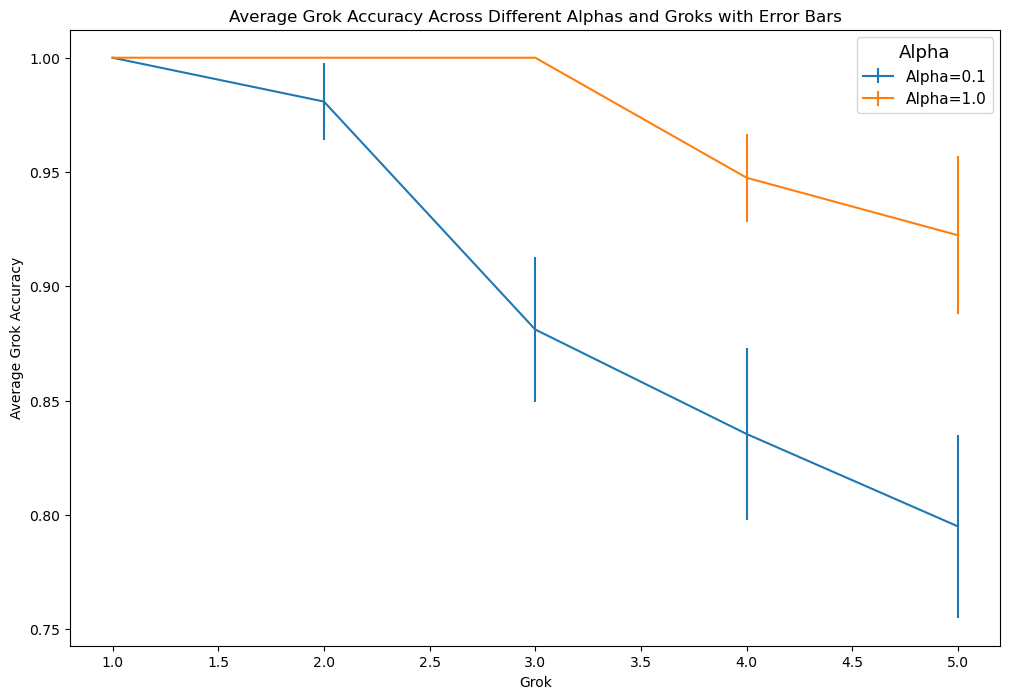

In [5]:
# Initialize a list to store filtered rows
top_10_df_list = []

# For each experiment, get the top 10 rows with the lowest 'testing_loss'
for experiment_id in df['experiment_id'].unique():
    experiment_df = df[df['experiment_id'] == experiment_id]
    top_10_df = experiment_df.nsmallest(10, 'test_loss')
    top_10_df_list.append(top_10_df)

# Concatenate the filtered DataFrames
top_10_df = pd.concat(top_10_df_list, ignore_index=True)

# Group by 'alpha', 'grok' and calculate the mean and standard error of the mean (sem) for 'grok_accuracy'
grouped_df = top_10_df.groupby(['alpha', 'grok'])['grok_accuracy'].agg(['mean', 'sem']).reset_index()

plt.figure(figsize=(12, 8))

# Plot each alpha
for alpha in grouped_df['alpha'].unique():
    alpha_df = grouped_df[grouped_df['alpha'] == alpha]
    plt.errorbar(alpha_df['grok'], alpha_df['mean'], yerr=alpha_df['sem'], label=f'Alpha={alpha}')

plt.xlabel('Grok')
plt.ylabel('Average Grok Accuracy')
plt.title('Average Grok Accuracy Across Different Alphas and Groks with Error Bars')
plt.legend(title='Alpha', title_fontsize='13', fontsize='11')
plt.show()

## Aggregate grok plot

/state/partition1/slurm_tmp/23880464.0.0/ipykernel_3642639/959286293.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  copper_map = cm.get_cmap('copper')


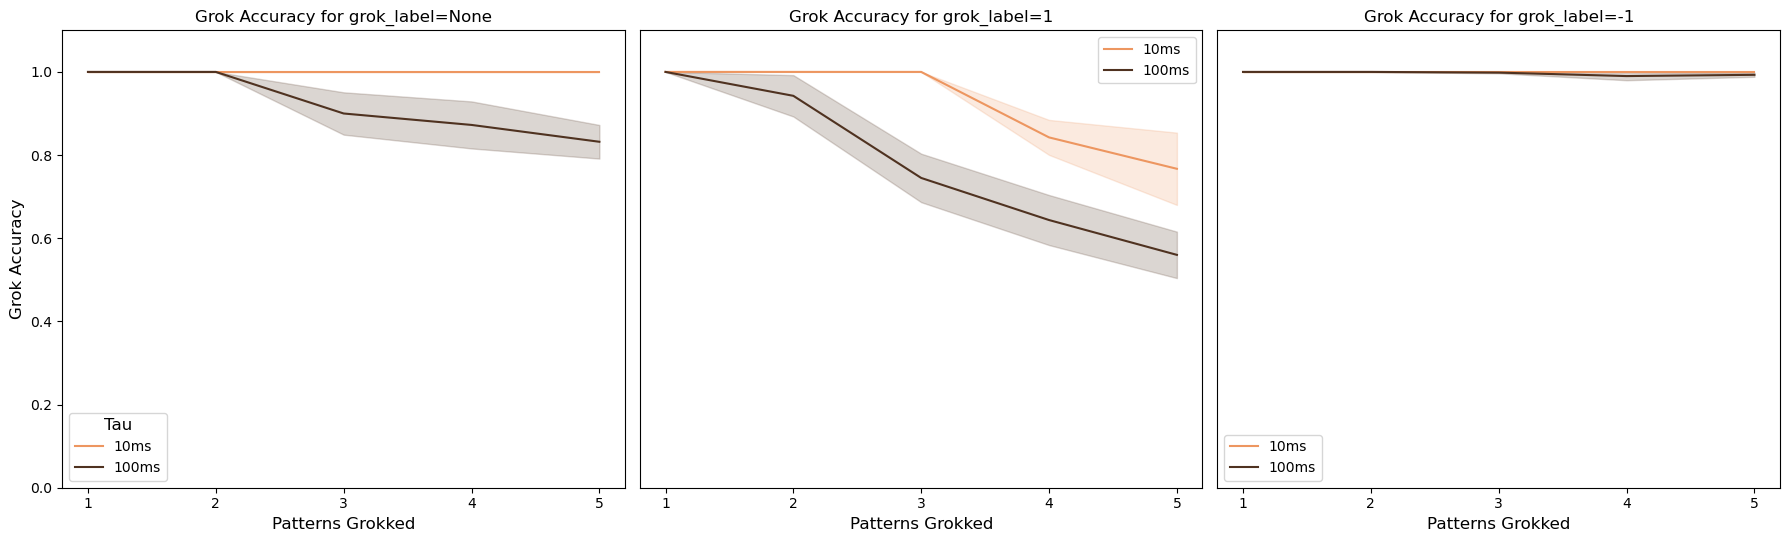

In [6]:
import matplotlib.cm as cm

# Initialize a list to store filtered rows
top_10_df_list = []

# For each experiment, get the top 10 rows with the lowest 'test_loss'
for experiment_id in df['experiment_id'].unique():
    experiment_df = df[df['experiment_id'] == experiment_id]
    top_10_df = experiment_df.nsmallest(10, 'test_loss')
    top_10_df_list.append(top_10_df)

# Concatenate the filtered DataFrames
top_10_df = pd.concat(top_10_df_list, ignore_index=True)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Changed to 1 row and 3 columns
grok_labels = [None, 1, -1]
alpha_label_mapping = {0.1: '100ms', 1.0: '10ms'}
copper_map = cm.get_cmap('copper')

for j, grok_label in enumerate(grok_labels):
    # Filter df for each grok_label
    if grok_label is None:
        filtered_df = top_10_df[pd.isna(top_10_df['grok_label'])]
    else:
        filtered_df = top_10_df[top_10_df['grok_label'] == grok_label]
    
    # Plot each alpha with copper color map
    for alpha in sorted(filtered_df['alpha'].unique(), reverse=True):  # sorted in descending order
        alpha_df = filtered_df[filtered_df['alpha'] == alpha]
        if alpha == 0.1:
            fixed_alpha = 0.25
        else:
            fixed_alpha = 0.75
        line_color = copper_map(fixed_alpha)
        sns.lineplot(x='grok', y='grok_accuracy', data=alpha_df, errorbar='se', ax=axs[j], label=alpha_label_mapping.get(alpha, f'Alpha={alpha}'), color=line_color)
    
    axs[j].set_xlabel('Patterns Grokked', fontsize='12')
    axs[j].set_title(f'Grok Accuracy for grok_label={grok_label}')
    axs[j].set_xticks(range(1, 6))
    axs[j].set_ylim([0.0, 1.1])  # Set y-axis limit
    
    if j == 0:
        axs[j].legend(title='Tau', title_fontsize='12', fontsize='10')
        axs[j].set_ylabel('Grok Accuracy', fontsize='12')
    else:
        axs[j].set_yticklabels([])  # Remove y-axis tick labels
        axs[j].set_ylabel('')  # Remove y-axis label
        axs[j].set_yticks([])  # Remove y-axis ticks

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()